In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
# Add the parent directory of 'src' to the Python path
import os
import sys


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:


file_path = '../data/longman-communication-3000.json'
data = load_longman_data(file_path)
s1_words = filter_s1_words(data)


Found config file at: c:\Users\i5\Documents\Python Scripts\audio-language-trainer\src\config.json
Language name: Swedish determined from code sv
Successfully loaded config from: c:\Users\i5\Documents\Python Scripts\audio-language-trainer\src\config.json
Multiple country codes available for en: en-AU, en-GB, en-IN, en-US


In [117]:
s1_vocab_list = defaultdict(list)

In [118]:
for pos in s1_words.keys():
    if pos in ['v', 'auxillary']:
        s1_vocab_list['verbs'] = s1_words[pos]
    else:
        s1_vocab_list['vocab'].extend(s1_words[pos])

In [165]:
verb_list = [word.lower() for word in s1_vocab_list['verbs']]
vocab_list = [word.lower() for word in s1_vocab_list['vocab']]

In [166]:

verb_list_set = set(verb_list)
vocab_list_set = set(vocab_list)

In [167]:
from src.utils import extract_substring_matches, extract_vocab_and_pos, extract_spacy_lowercase_words
from src.utils import get_verb_and_vocab_lists
from typing import Set
from src.phrase import *

def generate_phrases_loop(
    verb_list_set: Set[str],
    vocab_list_set: Set[str],
    max_iterations: int = 10
) -> List[str]:
    
    LONGMAN_PHRASES = []
    all_verbs_used = set()
    iteration_count = 0

    while (len(vocab_list_set) >= 5) and iteration_count < max_iterations:
        iteration_count += 1

        if len(vocab_list_set) < 150:
            # Switch to minimal phrase generation
            response = generate_minimal_phrases_with_llm(list(vocab_list_set))
            new_phrases = extract_json_from_llm_response(response)['phrases']
            vocab_used = extract_vocab_and_pos(new_phrases)
            words_used = get_verb_and_vocab_lists(vocab_used)
            verb_list_set.difference_update(words_used['verbs'])
            vocab_list_set.difference_update(words_used['vocab'])

            #match on text as well
            all_lowercase_words = extract_spacy_lowercase_words(new_phrases)
            verb_list_set.difference_update(all_lowercase_words)
            vocab_list_set.difference_update(all_lowercase_words)

            #match on substring
            substring_matches = extract_substring_matches(new_phrases, vocab_list_set)
            vocab_list_set.difference_update(substring_matches)

            LONGMAN_PHRASES.extend(new_phrases)

            print(f"Iteration {iteration_count}/{max_iterations}")
            print(f"Generated {len(new_phrases)} phrases - with minimal phrase prompt")
            print(f"We have {len(verb_list_set)} verbs and {len(vocab_list_set)} vocab words left")
            continue
        else:
            if len(verb_list_set) < 10:
                num_phrases = min(len(vocab_list_set), 100)  # Focus on exhausting vocab
                verb_list_set.update(all_verbs_used)  # Reintroduce all used verbs
            elif len(verb_list_set) < 50 and len(vocab_list_set) > 100:
                num_phrases = min(len(verb_list_set) * 2, 100)  # Ensure we use all verbs
            else:
                num_phrases = 100

        verb_sample_size = min(75, len(verb_list_set))
        vocab_sample_size = min(75 * 3, len(vocab_list_set))

        verb_list_for_prompt = random.sample(list(verb_list_set), k=verb_sample_size)
        vocab_list_for_prompt = random.sample(list(vocab_list_set), k=vocab_sample_size)

        response = generate_phrases_with_llm(
            verb_list=verb_list_for_prompt,
            vocab_list=vocab_list_for_prompt,
            num_phrases=num_phrases
        )
        
        new_phrases = extract_json_from_llm_response(response)['phrases']
        LONGMAN_PHRASES.extend(new_phrases)
        
        vocab_used = extract_vocab_and_pos(new_phrases)
        words_used = get_verb_and_vocab_lists(vocab_used)

        print(f"{len(words_used['vocab'])} vocab words extracted in total")
        overlap = len(set(words_used['vocab']).intersection(vocab_list_set))
        print(f"{overlap} words are found in the vocab_list_set")

        verb_list_set.difference_update(words_used['verbs'])
        vocab_list_set.difference_update(words_used['vocab'])

        #match on text as well
        all_lowercase_words = extract_spacy_lowercase_words(new_phrases)
        vocab_list_set.difference_update(all_lowercase_words)

        all_verbs_used.update(words_used['verbs'])

        print(f"Iteration {iteration_count}/{max_iterations}")
        print(f"Generated {len(new_phrases)} phrases")
        print(f"We have {len(verb_list_set)} verbs and {len(vocab_list_set)} vocab words left")

    if iteration_count == max_iterations:
        print(f"Reached maximum number of iterations ({max_iterations}). Stopping phrase generation.")
    else:
        print("All words have been used. Phrase generation complete.")

    return LONGMAN_PHRASES

In [168]:
final_phrases = generate_phrases_loop(
    verb_list_set,
    vocab_list_set,
    max_iterations=15
)




217 vocab words extracted in total
156 words are found in the vocab_list_set
Iteration 1/15
Generated 99 phrases
We have 118 verbs and 548 vocab words left
255 vocab words extracted in total
103 words are found in the vocab_list_set
Iteration 2/15
Generated 100 phrases
We have 37 verbs and 427 vocab words left
232 vocab words extracted in total
82 words are found in the vocab_list_set
Iteration 3/15
Generated 73 phrases
We have 1 verbs and 342 vocab words left
224 vocab words extracted in total
49 words are found in the vocab_list_set
Iteration 4/15
Generated 100 phrases
We have 143 verbs and 293 vocab words left
254 vocab words extracted in total
53 words are found in the vocab_list_set
Iteration 5/15
Generated 99 phrases
We have 64 verbs and 238 vocab words left
249 vocab words extracted in total
40 words are found in the vocab_list_set
Iteration 6/15
Generated 104 phrases
We have 3 verbs and 194 vocab words left
251 vocab words extracted in total
41 words are found in the vocab_list

In [169]:
with open("../outputs/test/phrases.txt", "w", encoding="utf-8") as f:
    for phrase in final_phrases:
        f.write(phrase + "\n")

In [181]:
import io
import matplotlib.pyplot as plt
from PIL import Image

def display_generated_image(image_data):
    """
    Display the generated image in a Jupyter notebook.
    
    :param image_data: Bytes of the image data
    :param phrase: The phrase used to generate the image
    """
    # Convert image bytes to a PIL Image
    image = Image.open(io.BytesIO(image_data))
    
    # Set up the plot
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [211]:
final_phrases

['The driver will face terrible traffic on holiday',
 'I need to read the important letter quickly',
 'They enjoyed the beautiful garden until late afternoon',
 'She might forget to bring her lunch today',
 'We must decide which movie to watch',
 'The kids love to sing in the rain',
 'He will build a proper table for us',
 'They chose to spend their holiday down south',
 'I plan to organize the office party soon',
 "She couldn't afford the expensive birthday gift unfortunately",
 'We should thank dad for the useful advice',
 'The teacher will mention your good work today',
 'They continued to cook despite the bad weather',
 "He might lose his job if he's late",
 'We need to reduce our expenses this month',
 'She will write a letter to the local newspaper',
 'They decided to join the football team yesterday',
 'He wants to grow vegetables in his garden',
 'We should compare prices before making a decision',
 'She will answer the phone call from work',
 'They plan to shut the shop early 

In [220]:
PHRASES_DICT = {"anki" : {"corrected_phrase_list" : final_phrases[:100]}}

In [215]:
from src.generate import add_translations


translated_phrases_dict = add_translations(PHRASES_DICT)

Beginning translation for anki
Translated phrases



In [234]:
with open("../outputs/test/longman_1000_translated.json", "w") as f:
    json.dump(translated_phrases_dict, f, indent=2)

In [236]:
from src.utils import create_test_story_dict
from src.anki import export_to_anki
from src.generate import add_audio

num_phrases = 50
for from_index in range(0, len(final_phrases), num_phrases):
    partial_dict = create_test_story_dict(translated_phrases_dict, story_parts=1, phrases=num_phrases, from_index=from_index)
    translated_phrases_dict_audio = await add_audio(partial_dict)

    export_to_anki(translated_phrases_dict_audio, "../outputs/test", f"longman_1000_swedish_{from_index}", deck_name="Longman 1000 - Swedish")

Text-to-speech for phrases done

Anki deck exported to ../outputs/test\longman_1000_swedish_0_anki_deck.apkg
Deleted temporary file: ../outputs/test\0a5f9584-57e3-43f6-9277-ae8644b1f498.mp3
Deleted temporary file: ../outputs/test\54e2f304-968e-46d6-9287-be677b4ea99a.mp3
Deleted temporary file: ../outputs/test\bf904f7e-fe78-42dd-9dd6-b3c75f2834de.mp3
Deleted temporary file: ../outputs/test\512d479f-5587-4b39-b555-5fb7fdb27b5b.mp3
Deleted temporary file: ../outputs/test\2c6e7647-50f7-4401-b5ff-13463bba92ea.mp3
Deleted temporary file: ../outputs/test\99bbd857-174f-4049-b83b-0ff2de58db69.mp3
Deleted temporary file: ../outputs/test\f6b61695-067e-46c2-9d1d-0b285a30eb66.mp3
Deleted temporary file: ../outputs/test\a330c7d0-bb6c-44d4-9e78-1f5bb835c5fd.mp3
Deleted temporary file: ../outputs/test\d802a4bc-e20a-4e0f-ae50-f67efca3f386.mp3
Deleted temporary file: ../outputs/test\80616b47-766e-4622-a654-b1915a22650c.mp3
Deleted temporary file: ../outputs/test\4739a9b7-a7f5-442d-b452-e590c157f323.mp3


In [229]:
#Saving as pickle file to retain audio data
import pickle


with open(F'../outputs/test/longman_1000_audio.pkl', 'wb') as file:
    pickle.dump(translated_phrases_dict_audio, file)

In [191]:
from src.utils import generate_language_learning_image


im = generate_language_learning_image(final_phrases[0])

our image gen prompt is 
    Create a vivid, memorable image for language learners based on the following description:
    
    A frustrated driver stuck in a massive traffic jam on a holiday-decorated highway. The driver's expression is exasperated, with hands gripping the steering wheel tightly. Through the windshield, a sea of red taillights stretches into the distance. Colorful holiday decorations and banners line the road, contrasting with the gloomy atmosphere of gridlock. The sky is a warm orange, suggesting a long day of travel. In the rearview mirror, a "Holiday Traffic Ahead" sign is visible.
    
    The image should be:
    - Colorful and engaging
    - Styled like a modern, slightly stylized illustration (not photorealistic)
    - Suitable for display on a mobile phone screen (square 1:1 aspect ratio)
    - Clear and easily understandable at a glance
    


In [200]:
from src.utils import create_image_generation_prompt


prompt = create_image_generation_prompt(final_phrases[5])
print()

In [204]:
prompt

"\n    Create a vivid, memorable image for language learners based on the following description:\n    \n    A group of cheerful children, aged 6-10, standing in a light rain shower, their faces upturned and mouths open wide in song. They wear colorful raincoats and boots, splashing in small puddles. Musical notes float visibly around their heads. The background shows a park with wet grass and trees. The overall scene is bright and joyful, with a soft blue-gray sky and vibrant rainbow colors from the children's clothing.\n    \n    The image should be:\n    - Colorful and engaging\n    - Styled like a modern, slightly stylized illustration (not photorealistic)\n    - Suitable for display on a mobile phone screen (square 1:1 aspect ratio)\n    - Clear and easily understandable at a glance\n    "

In [203]:
response

ImageGenerationResponse(images=[])

In [206]:
from vertexai.preview.vision_models import ImageGenerationModel
model = ImageGenerationModel.from_pretrained("imagen-3.0-fast-generate-001")
response = model.generate_images(
    prompt=prompt,
    aspect_ratio="1:1",
    # Optional:
    number_of_images=1,
)
response[0].show()

IndexError: list index out of range

In [210]:
response.images

[]

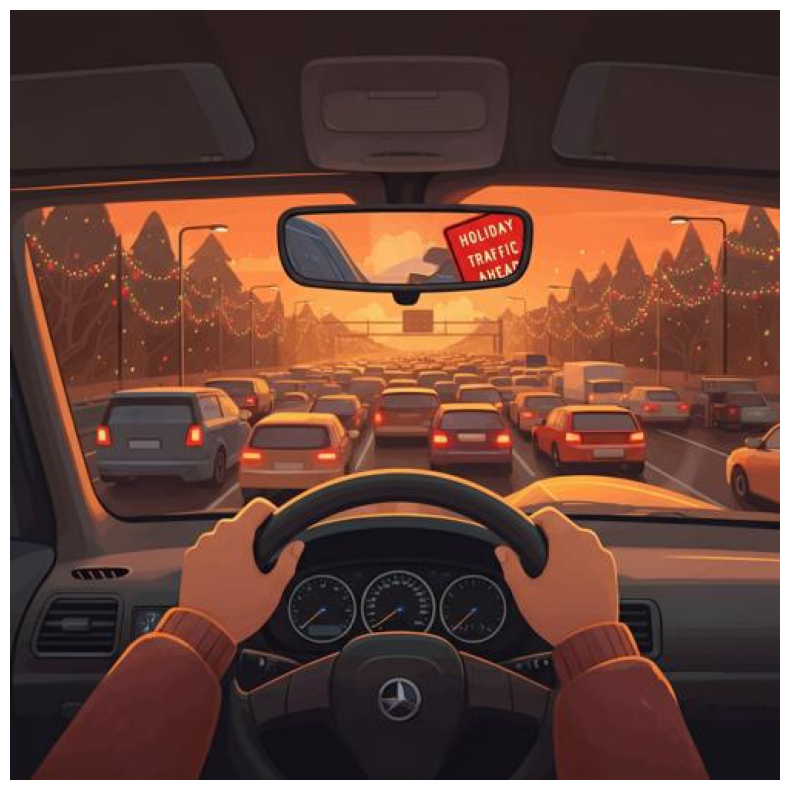

In [192]:
display_generated_image(im)

In [23]:
vocab_list[:75]

['free',
 'that',
 'police',
 'egg',
 'east',
 'what',
 'just',
 'together',
 'money',
 'pound',
 'woman',
 'each',
 'bye',
 'from',
 'north',
 'though',
 'end',
 'back',
 'busy',
 'I',
 'important',
 'be',
 'many',
 'such',
 'tired',
 'form',
 'completely',
 'success',
 'ready',
 'ahead',
 'video',
 'talk',
 'situation',
 'public',
 'boat',
 'programme',
 'first',
 'wife',
 'properly',
 'area',
 'other',
 'rid',
 'more',
 'data',
 'death',
 'telephone',
 'through',
 'west',
 'half',
 'file',
 'right',
 'hospital',
 'across',
 'one',
 'short',
 'term',
 'down',
 'outside',
 'before',
 'so',
 'while',
 'large',
 'unless',
 'we',
 'last',
 "o'clock",
 'sister',
 'process',
 'which',
 'now',
 'television',
 'can',
 'each other',
 'share',
 'them']

In [ ]:

print(f"Generated {len(phrases)} phrases:")
for phrase in phrases:
    print(phrase)

print(f"\nUsed {len(used_words)} unique words.")

# Update word usage
data = update_word_usage(data, used_words)


In [ ]:

# Optionally, save the updated data back to the file
with open(file_path, 'w') as file:
    json.dump(data, file, indent=2)